In [1]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [2]:
!pip install gymnasium

In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
from collections import defaultdict
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
import random

def load_traffic_states(csv_path):
    df = pd.read_csv(csv_path)

    # Hedef yolları sabit sırayla tanımla
    yol_sirasi = [
        "Hatboyu-2 Cd.",
        "Gazi Yakup Satar Cd. (Kuzey)",
        "Gazi Yakup Satar Cd. (Güney)",
        "Zubeyde Hanim Blv.",
        "Ihlamur Agaci Sk."
    ]

    traffic_states = []

    # Zaman adımlarına göre gruplama
    for zaman, grup in df.groupby("zaman"):
        state = []
        for yol in yol_sirasi:
            yol_verisi = grup[grup["yol_ismi"] == yol]
            if not yol_verisi.empty:
                ortalama = yol_verisi[["bas_rengi", "orta_rengi", "son_rengi"]].mean(axis=1).values[0]
            else:
                ortalama = 0  # eksikse 0 say
            state.append(round(ortalama, 2))
        traffic_states.append({
            "time": zaman,
            "state": state
        })

    return traffic_states


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 178, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 63, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

In [4]:
states = load_traffic_states("/kaggle/input/kavsakdata/trafik_kayit_final.csv")

for s in states[:3]:
    print(s)

{'time': '2025-04-15 21:36:08', 'state': [0.0, 0.0, 0, 0.0, 0.33]}
{'time': '2025-04-15 21:36:19', 'state': [0.0, 0.0, 0, 0.0, 0.33]}
{'time': '2025-04-15 21:36:31', 'state': [0.0, 0.0, 0, 0.0, 0.33]}


In [21]:
def calculate_reward(state, green, prev_green, waiting_counts):
    selected_density = np.mean(state[green])
    reward = selected_density

    # Çok boş yeri seçmişse ceza
    if selected_density < 1.0:
        reward -= 2.0

    # Sürekli değiştiriyorsa ceza
    if prev_green is not None and set(green) != set(prev_green):
        reward -= 0.5
    else:
        reward += 0.1

    # Çok uzun süre bekleyen varsa ceza
    long_wait_penalty = sum(1 for w in waiting_counts if w > 8)
    reward -= 0.2 * long_wait_penalty

    return reward


In [40]:
class TrafficEnv(Env):
    def __init__(self, reward_fn=None, max_steps=100):
        super().__init__()
        self.observation_space = Box(low=0, high=4, shape=(5,), dtype=np.float32)
        self.action_space = Discrete(3)  # 3 junction control sets
        self.state = None
        self.max_steps = max_steps
        self.current_step = 0
        self.prev_action = None
        self.max_density = 4.0
        self.reward_fn = reward_fn
        self.waiting_counts = np.zeros(5, dtype=int)

        # Yeni junction gruplari
        self.green_sets = {
            0: [1, 2],  # Junction A
            1: [0, 4],  # Junction B
            2: [0, 3]   # Junction C
        }

    def reset(self, seed=None, options=None):
        self.state = np.random.uniform(0, 4, size=(5,)).astype(np.float32)
        self.current_step = 0
        self.prev_action = None
        self.waiting_counts = np.zeros(5, dtype=int)
        return self.state.copy(), {}

    def step(self, action):
        self.current_step += 1
        new_state = self.state.copy()
        green = self.green_sets[action]
    
        for i in range(5):
            if i in green:
                new_state[i] = max(0.0, new_state[i] - 1.0)
                self.waiting_counts[i] = 0
            else:
                new_state[i] = min(self.max_density, new_state[i] + 0.2)
                self.waiting_counts[i] += 1
    
        prev_green = self.green_sets[self.prev_action] if self.prev_action is not None else None
        reward = float(self.reward_fn(self.state, green, prev_green, self.waiting_counts)) if self.reward_fn else float(np.mean(self.state[green]))
    
        self.state = new_state
        self.prev_action = action
        done = self.current_step >= self.max_steps
        return new_state.copy(), reward, done, False, {}

    def render(self):
        print(f"Step {self.current_step} | State: {np.round(self.state, 2)}")

In [41]:
# states = load_traffic_states("trafik_kayit1.csv")
env = TrafficEnv(reward_fn=calculate_reward)
check_env(env, warn=True)

state, _ = env.reset()
done = False

while not done:
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    env.render()

Step 1 | State: [2.13 1.08 1.63 2.74 1.41]
Step 2 | State: [1.13 1.28 1.83 1.74 1.61]
Step 3 | State: [0.13 1.48 2.03 1.94 0.61]
Step 4 | State: [0.   1.68 2.23 2.14 0.  ]
Step 5 | State: [0.2  0.68 1.23 2.34 0.2 ]
Step 6 | State: [0.4  0.   0.23 2.54 0.4 ]
Step 7 | State: [0.   0.2  0.43 2.74 0.  ]
Step 8 | State: [0.2  0.   0.   2.94 0.2 ]
Step 9 | State: [0.   0.2  0.2  1.94 0.4 ]
Step 10 | State: [0.2  0.   0.   2.14 0.6 ]
Step 11 | State: [0.4  0.   0.   2.34 0.8 ]
Step 12 | State: [0.   0.2  0.2  2.54 0.  ]
Step 13 | State: [0.2  0.   0.   2.74 0.2 ]
Step 14 | State: [0.   0.2  0.2  1.74 0.4 ]
Step 15 | State: [0.2  0.   0.   1.94 0.6 ]
Step 16 | State: [0.4  0.   0.   2.14 0.8 ]
Step 17 | State: [0.   0.2  0.2  2.34 0.  ]
Step 18 | State: [0.2  0.   0.   2.54 0.2 ]
Step 19 | State: [0.   0.2  0.2  2.74 0.  ]
Step 20 | State: [0.   0.4  0.4  1.74 0.2 ]
Step 21 | State: [0.   0.6  0.6  1.94 0.  ]
Step 22 | State: [0.   0.8  0.8  2.14 0.  ]
Step 23 | State: [0.   1.   1.   2.34 0. 

In [8]:
def state_to_key(state):
    return tuple([int(np.ceil(x)) for x in state])  # ceil hâlâ mantıklı burada


In [9]:
def train_q_learning(env, episodes=5000, alpha=0.1, gamma=0.9, epsilon=0.3):
    q_table = defaultdict(lambda: np.zeros(env.action_space.n))

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        prev_action = None

        while not done:
            state_key = state_to_key(state)

            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state_key])

            reward = calculate_reward(state, action, prev_action)

            next_state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_key = state_to_key(next_state)

            old_value = q_table[state_key][action]
            future_max = np.max(q_table[next_key])
            new_value = old_value + alpha * (reward + gamma * future_max - old_value)
            q_table[state_key][action] = new_value

            prev_action = action
            state = next_state

    return q_table

In [10]:
q_table = train_q_learning(env, episodes=1000)

sample_state = [0, 0, 0, 1, 1]
print("State key:", state_to_key(sample_state))
print("Q-values:", q_table[state_to_key(sample_state)])
print("En iyi aksiyon:", np.argmax(q_table[state_to_key(sample_state)]))

KeyboardInterrupt: 

In [ ]:
# Örnek state için en iyi aksiyon:
sample_state = [2.3, 3.1, 0.4, 1.9, 1.6]
best_action = np.argmin(q_table[state_to_key(sample_state)])
print("En iyi aksiyon:", best_action)

In [ ]:
q_table[state_to_key(sample_state)]

In [ ]:
# Örnek state için en iyi aksiyon:
sample_state = [0, 0, 0, 1, 0]
best_action = np.argmin(q_table[state_to_key(sample_state)])
print("En iyi aksiyon:", best_action)

In [42]:
model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=5e-4,
    buffer_size=10000,
    learning_starts=1000,
    batch_size=64,
    gamma=0.95,
    exploration_fraction=0.1,
    exploration_final_eps=0.05,
    target_update_interval=250,
    train_freq=1,
    gradient_steps=1
)

model.learn(total_timesteps=100000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -162     |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5037     |
|    time_elapsed     | 0        |
|    total_timesteps  | 400      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -158     |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5331     |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -159   

In [43]:
def generate_realistic_multi_sim(model, steps=50, print_output=True):
    state = np.random.uniform(0, 4, size=(5,)).astype(np.float32)
    max_density = 4.0
    state_log = []
    prev_action = None
    action_counts = np.zeros(3)
    waiting_counts = np.zeros(5, dtype=int)

    green_sets = {
        0: [1, 2],
        1: [0, 4],
        2: [0, 3]
    }

    for step in range(steps):
        action, _ = model.predict(state, deterministic=True)
        action = int(action)

        if prev_action is not None:
            current = green_sets[action]
            prev = green_sets[prev_action]
            if np.mean(state[prev]) >= np.mean(state[current]) - 0.2:
                action = prev_action

        action_counts[action] += 1
        green = green_sets[action]

        new_state = state.copy()
        for i in range(5):
            if i in green:
                new_state[i] = max(0.0, new_state[i] - np.random.uniform(0.6, 1.0))
                waiting_counts[i] = 0
            else:
                increase = np.random.uniform(0.05, 0.2)
                if state[i] < 3.0:
                    increase += 0.05
                new_state[i] = min(max_density, new_state[i] + increase)
                waiting_counts[i] += 1

        for i in range(5):
            if action_counts[action] < step * 0.05:
                new_state[i] = min(max_density, new_state[i] + 0.05)

        state_log.append({
            "step": step,
            "state": state.tolist(),
            "action": int(action),
            "next_state": new_state.tolist(),
            "waiting_counts": waiting_counts.tolist(),
            "prev_action": int(prev_action) if prev_action is not None else None
        })

        if print_output:
            print(f"[{step}] State: {np.round(state, 1)} → Action: {action} ({green}) → Next: {np.round(new_state, 1)} | Waiting: {waiting_counts.tolist()}")

        prev_action = action
        state = new_state

    return state_log

In [44]:
state_log = generate_realistic_multi_sim(model, steps=1000)

# İstersen CSV'ye yaz:
import pandas as pd
df = pd.DataFrame(state_log)
df.to_csv("model_test_simulasyon.csv", index=False)

[0] State: [2.3 1.1 0.3 0.9 3.2] → Action: 2 ([0, 3]) → Next: [1.4 1.3 0.5 0.2 3.3] | Waiting: [0, 1, 1, 0, 1]
[1] State: [1.4 1.3 0.5 0.2 3.3] → Action: 1 ([0, 4]) → Next: [0.7 1.5 0.8 0.5 2.7] | Waiting: [0, 2, 2, 1, 0]
[2] State: [0.7 1.5 0.8 0.5 2.7] → Action: 1 ([0, 4]) → Next: [0.  1.7 1.  0.6 1.9] | Waiting: [0, 3, 3, 2, 0]
[3] State: [0.  1.7 1.  0.6 1.9] → Action: 1 ([0, 4]) → Next: [0.  1.9 1.1 0.7 1. ] | Waiting: [0, 4, 4, 3, 0]
[4] State: [0.  1.9 1.1 0.7 1. ] → Action: 0 ([1, 2]) → Next: [0.1 0.9 0.3 0.9 1.1] | Waiting: [1, 0, 0, 4, 1]
[5] State: [0.1 0.9 0.3 0.9 1.1] → Action: 0 ([1, 2]) → Next: [0.2 0.1 0.  1.1 1.3] | Waiting: [2, 0, 0, 5, 2]
[6] State: [0.2 0.1 0.  1.1 1.3] → Action: 0 ([1, 2]) → Next: [0.5 0.  0.  1.3 1.5] | Waiting: [3, 0, 0, 6, 3]
[7] State: [0.5 0.  0.  1.3 1.5] → Action: 0 ([1, 2]) → Next: [0.6 0.  0.  1.6 1.6] | Waiting: [4, 0, 0, 7, 4]
[8] State: [0.6 0.  0.  1.6 1.6] → Action: 1 ([0, 4]) → Next: [0.  0.1 0.2 1.7 0.8] | Waiting: [0, 1, 1, 8, 0]
[

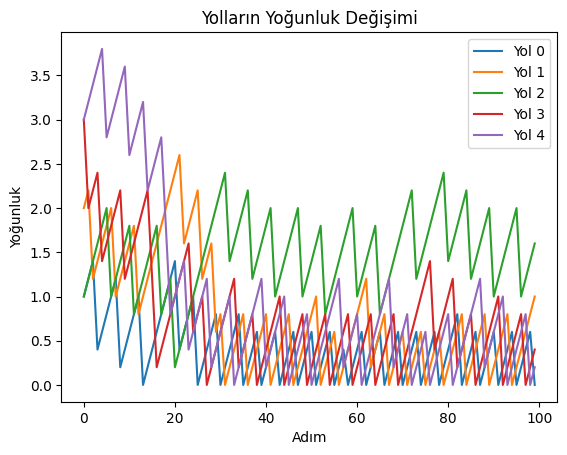

In [88]:
for i in range(5):
    plt.plot([step['state'][i] for step in state_log], label=f"Yol {i}")
plt.legend()
plt.title("Yolların Yoğunluk Değişimi")
plt.xlabel("Adım")
plt.ylabel("Yoğunluk")
plt.show()

In [43]:
def inspect_q_values(model, state):
    model.policy.eval()  # inference moduna geç
    with torch.no_grad():
        # Girdiyi uygun boyuta getir (batch_size=1)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        q_values = model.q_net(state_tensor)  # Q-değerlerini hesapla
        q_values = q_values.squeeze().numpy()  # [1, 5] → [5]
    return q_values

In [74]:
sample_state = [2.2, 0.2, 3.2, 1.2, 1.2]  # test etmek istediğin durum
q_vals = inspect_q_values(model, sample_state)

print("State:", sample_state)
print("Q-değerleri:", np.round(q_vals, 3))
print("En iyi aksiyon:", int(np.argmax(q_vals)))

State: [2.2, 0.2, 3.2, 1.2, 1.2]
Q-değerleri: [-0.309  0.181  0.013 -0.416  0.212]
En iyi aksiyon: 4


In [103]:
# Rastgele birkaç state için Q değerlerine bakalım
states_to_check = [
    [1.0, 2.0, 3.5, 3.9, 1.0],
    [3.0, 1.0, 4.0, 2.0, 3.0],
    [2.5, 2.5, 2.5, 2.5, 2.5]
]
for s in states_to_check:
    q = inspect_q_values(model, s)
    print(f"State: {s} -> Q: {np.round(q, 3)} -> Best: {np.argmax(q)}")


State: [1.0, 2.0, 3.5, 3.9, 1.0] -> Q: [3.337 4.549 4.952 4.865 3.317] -> Best: 2
State: [3.0, 1.0, 4.0, 2.0, 3.0] -> Q: [3.737 1.777 3.696 3.377 3.647] -> Best: 0
State: [2.5, 2.5, 2.5, 2.5, 2.5] -> Q: [1.434 1.374 1.388 1.393 1.422] -> Best: 0


In [81]:
test_states = [
    [4.0, 0.0, 4.0, 4.0, 4.0],
    [0.0, 0.0, 4.0, 4.0, 4.0],
    [2.0, 0.0, 3.2, 1.2, 1.2]
]

for s in test_states:
    q = inspect_q_values(model, s)
    print(f"State: {s} → Q: {np.round(q, 3)} → Best: {np.argmax(q)}")


State: [4.0, 0.0, 4.0, 4.0, 4.0] → Q: [ 0.434  0.257  0.274  0.035 -0.634] → Best: 0
State: [0.0, 0.0, 4.0, 4.0, 4.0] → Q: [ 0.682  0.4    0.363 -0.013 -0.485] → Best: 0
State: [2.0, 0.0, 3.2, 1.2, 1.2] → Q: [ 0.192  0.046  0.16   0.107 -0.334] → Best: 0
